In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from itertools import permutations, product, combinations
from scipy.stats import pearsonr, spearmanr

# Settings

In [2]:
analyses = ["Fastcore", "gimme", "iMAT", "init", "tinit"]

## Read the data

In [3]:
all_models = []
MEMs = []

for i,analysis in enumerate(analyses):       
    if analysis == "Fastcore":
        df = pd.read_csv("data\\"+analysis+"_rxnMatrix.csv", sep=",")
        df = df.drop(columns='Unnamed: 0')
    else:
        df = pd.read_csv("data\\"+analysis+"_rxnMatrix.csv", sep=";")
    
    df.columns = ["rxns"] +list(df.columns)[1:]
    models = list(df.columns[1:])
    #print(df.columns)
    models = list(map(lambda x: x.split("_")[1].split(".")[0]+"_"+analysis, models))
    #print(len(models))
    MEMs.append(models)
    all_models += models
    
    
    if i == 0:
        df_full = df
    else:
        df_full = pd.merge(df_full, df)
           
models = all_models

In [4]:
M = np.transpose(df_full.values[:,1:])

### Grouping by genotype

In [5]:
# WT
genotype0 = ["GSM1405493","GSM1405505","GSM1405517", 
              "GSM1405489","GSM1405501","GSM1405513",
              "GSM1405485","GSM1405497","GSM1405509",
              "GSM1405494","GSM1405506","GSM1405518",
              "GSM1405490","GSM1405502","GSM1405514",
              "GSM1405486","GSM1405498","GSM1405510"]
genotype0 = list(map(lambda x: x[0] + "_" + x[1], product(genotype0, analyses)))

# KO
genotype1 = ["GSM1405495","GSM1405507","GSM1405519",
              "GSM1405491","GSM1405503","GSM1405515",
              "GSM1405487","GSM1405499","GSM1405511",
              "GSM1405496","GSM1405508","GSM1405520",
              "GSM1405492","GSM1405504","GSM1405516",
              "GSM1405488","GSM1405500","GSM1405512"]
genotype1 = list(map(lambda x: x[0] + "_" + x[1], product(genotype1, analyses)))

genotype = (genotype0, genotype1)

### Grouping by diet

In [6]:
# LFnC
diet0 = ["GSM1405485","GSM1405497","GSM1405509","GSM1405487","GSM1405499","GSM1405511",
         "GSM1405486","GSM1405498","GSM1405510","GSM1405488","GSM1405500","GSM1405512"]

diet0 = list(map(lambda x: x[0] + "_" + x[1], product(diet0, analyses)))

# HFnC
diet1 = ["GSM1405489","GSM1405501","GSM1405513","GSM1405491","GSM1405503","GSM1405515",
         "GSM1405490","GSM1405502","GSM1405514","GSM1405492","GSM1405504","GSM1405516"]

diet1 = list(map(lambda x: x[0] + "_" + x[1], product(diet1, analyses)))

# HFC - F
diet2 = ["GSM1405493","GSM1405505","GSM1405517","GSM1405495","GSM1405507","GSM1405519",
         "GSM1405494","GSM1405506","GSM1405518","GSM1405496","GSM1405508","GSM1405520"]

diet2 = list(map(lambda x: x[0] + "_" + x[1], product(diet2, analyses)))

diet = (diet0, diet1, diet2)

### Grouping by gender

In [7]:
# F
gender0 = ["GSM1405493","GSM1405505","GSM1405517",
           "GSM1405489","GSM1405501","GSM1405513",
           "GSM1405485","GSM1405497","GSM1405509",
           "GSM1405495","GSM1405507","GSM1405519",
           "GSM1405491","GSM1405503","GSM1405515",
           "GSM1405487","GSM1405499","GSM1405511"]

gender0 = list(map(lambda x: x[0] + "_" + x[1], product(gender0, analyses)))

# M
gender1 = ["GSM1405494","GSM1405506","GSM1405518",
           "GSM1405490","GSM1405502","GSM1405514",
           "GSM1405486","GSM1405498","GSM1405510",
           "GSM1405496","GSM1405508","GSM1405520",
           "GSM1405492","GSM1405504","GSM1405516",
           "GSM1405488","GSM1405500","GSM1405512"]

gender1 = list(map(lambda x: x[0] + "_" + x[1], product(gender1, analyses)))

gender = (gender0, gender1)

### Grouping

In [8]:
groups = {"MEM": MEMs, "genotype": genotype, "diet": diet, "gender": gender}
labels = {"MEM":analyses, "genotype": ("WT","KO"), "diet": ("LFnC", "HFnC", "HFC"), "gender": ("F","M")}

## Preprocessing

Remove the reactions that are always 0 or always 1

In [9]:
M = M[:,~np.all(M==0, axis=0)]
M = M[:,~np.all(M==1, axis=0)]

In [10]:
M = np.array(M, dtype=float)

Zero centering the rows

In [11]:
#M = np.transpose(np.transpose(M) - np.mean(M, axis=1))
M = np.transpose((np.transpose(M) - np.mean(M, axis=1))/np.std(M, axis=1))
#np.mean(M, axis=1)

## PCA

In [12]:
pca = PCA(n_components=3)
comps = pca.fit_transform(M)
df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2', 'PC3'])
df['model'] = models
#df = df.set_index('model')

In [13]:
df_pca = pd.DataFrame()
df_pca = df_pca.append(pd.DataFrame(pca.explained_variance_).T)
df_pca = df_pca.append(pd.DataFrame(pca.explained_variance_ratio_).T)
df_pca.columns = ['PC1', 'PC2', 'PC3']
df_pca['label'] = ['explained variance', 'explained variance ratio']
df_pca = df_pca.set_index('label')
df_pca.to_csv("results_PCA_extended\\explained_variance.csv")

In [14]:
pca_explained = pca.explained_variance_ratio_

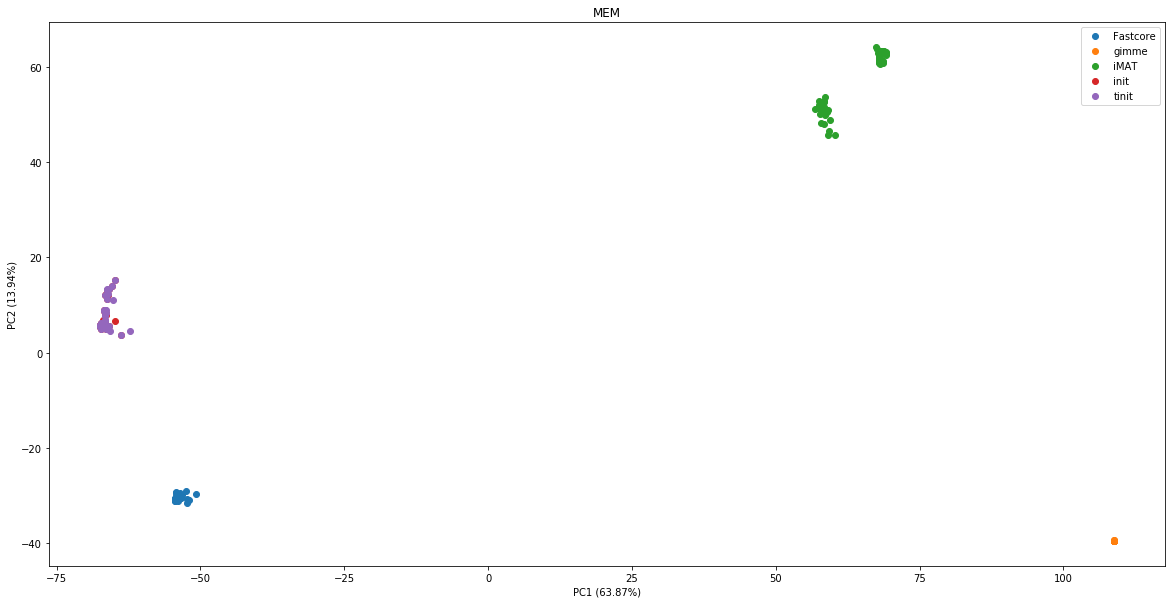

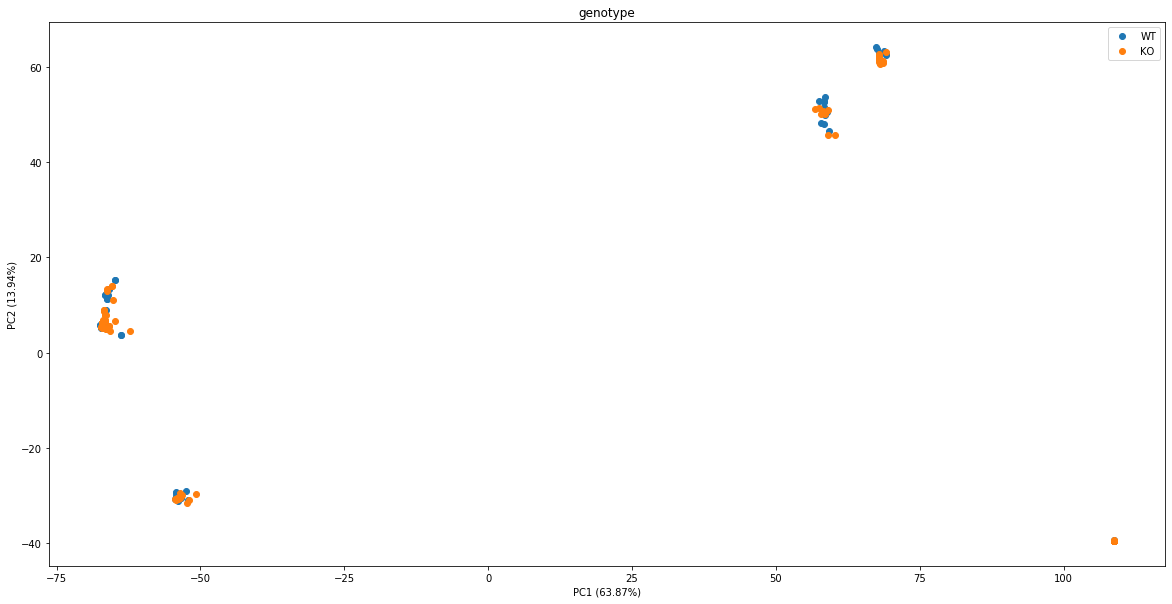

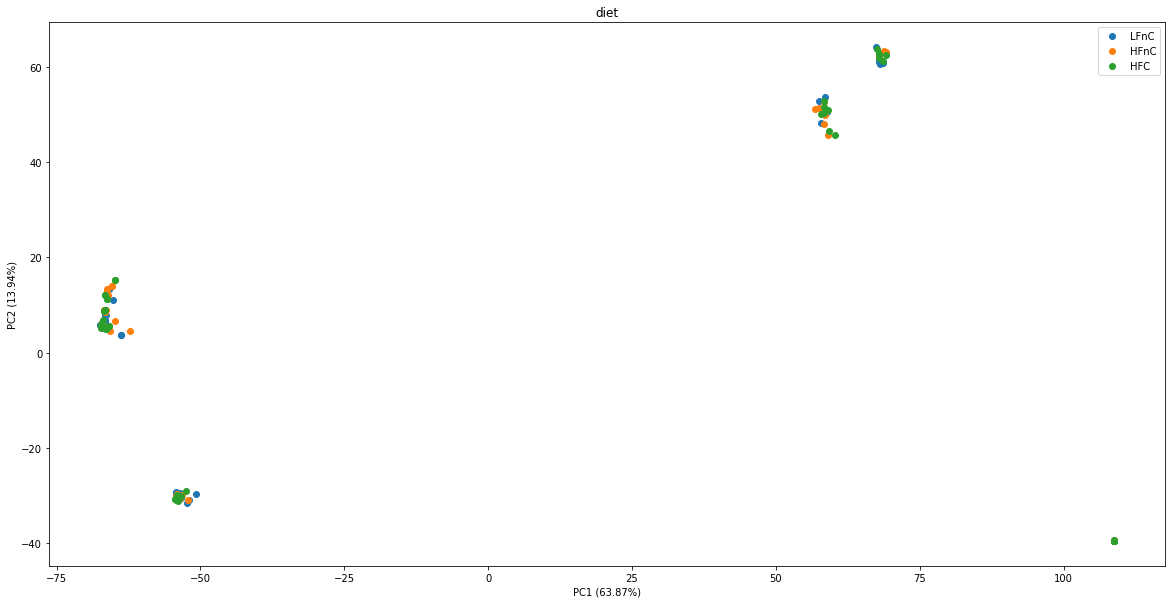

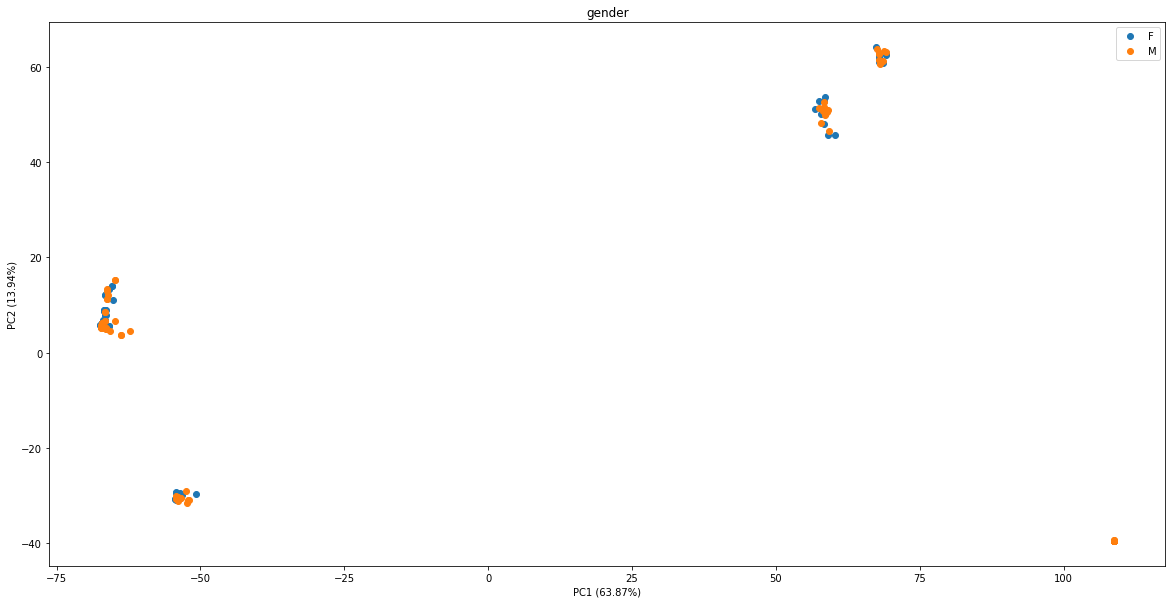

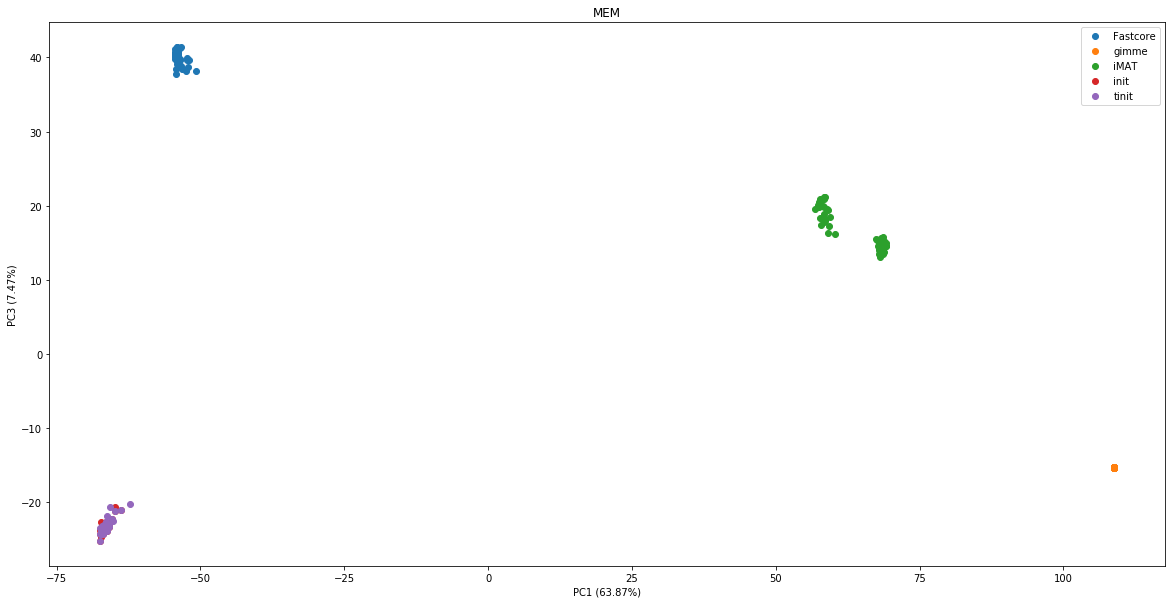

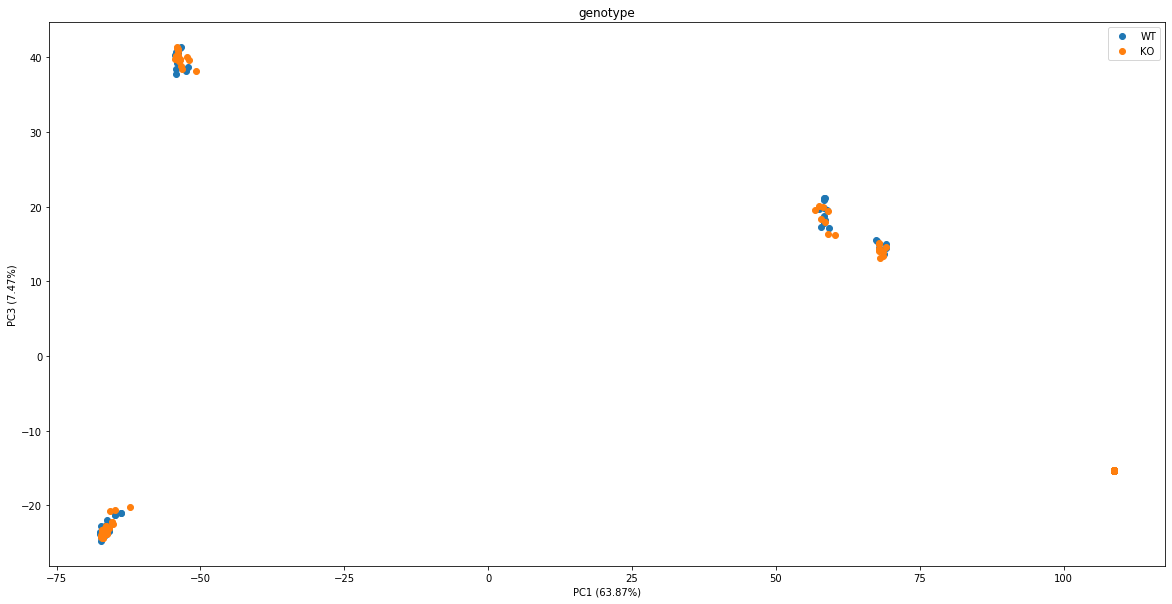

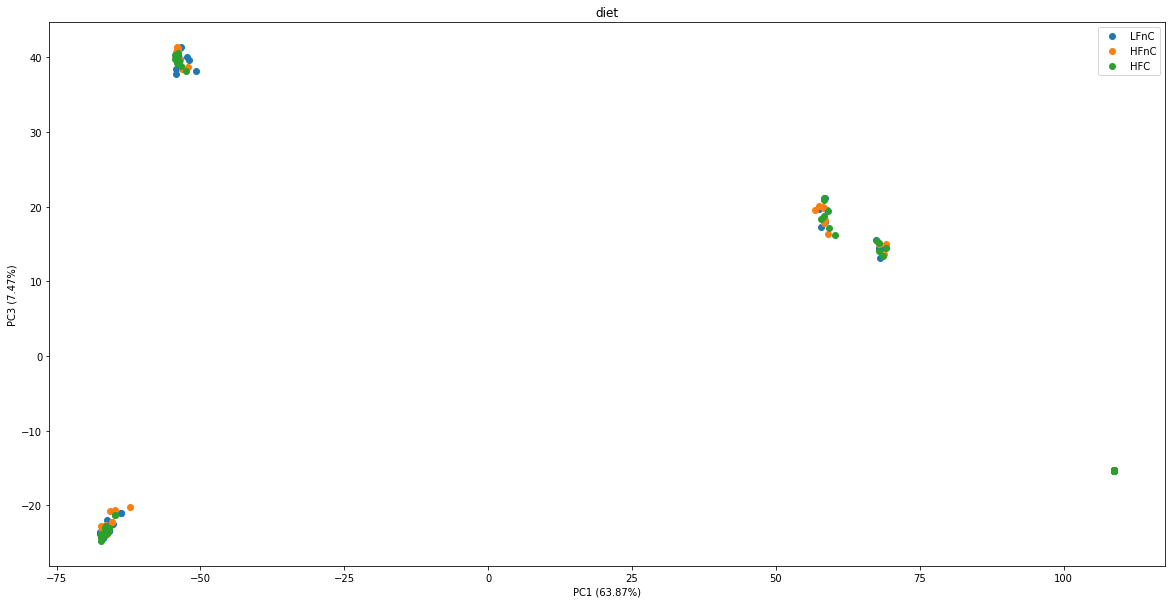

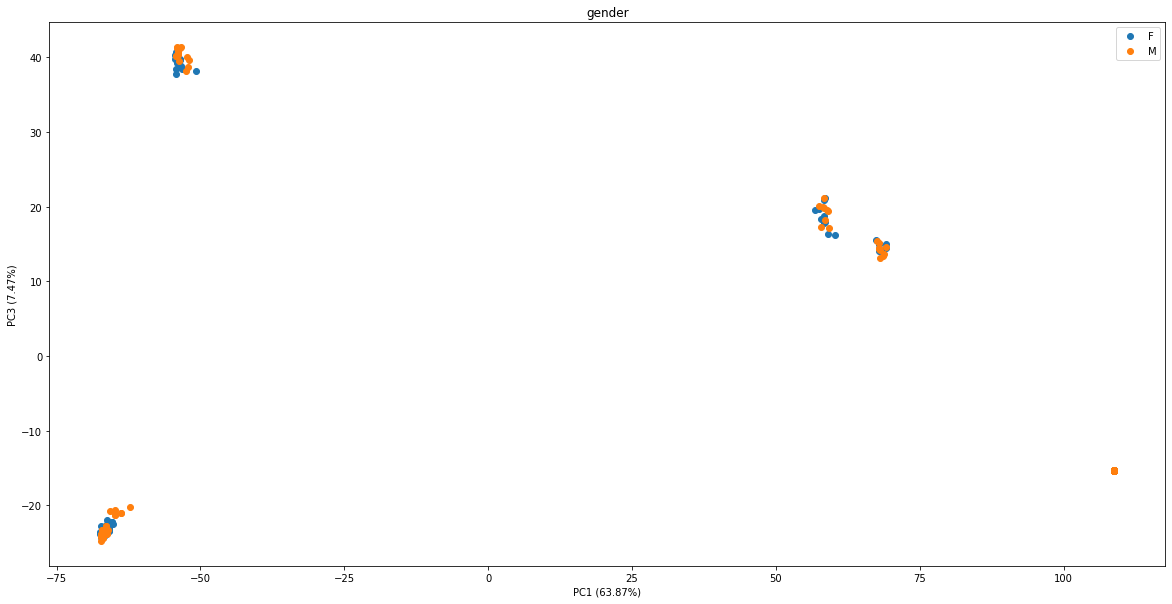

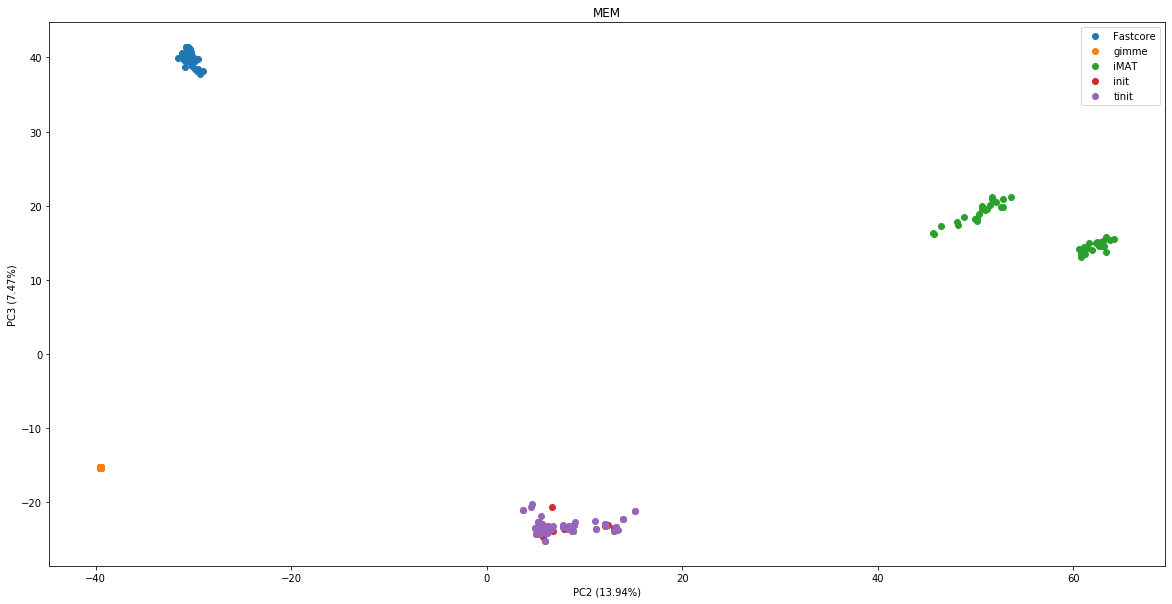

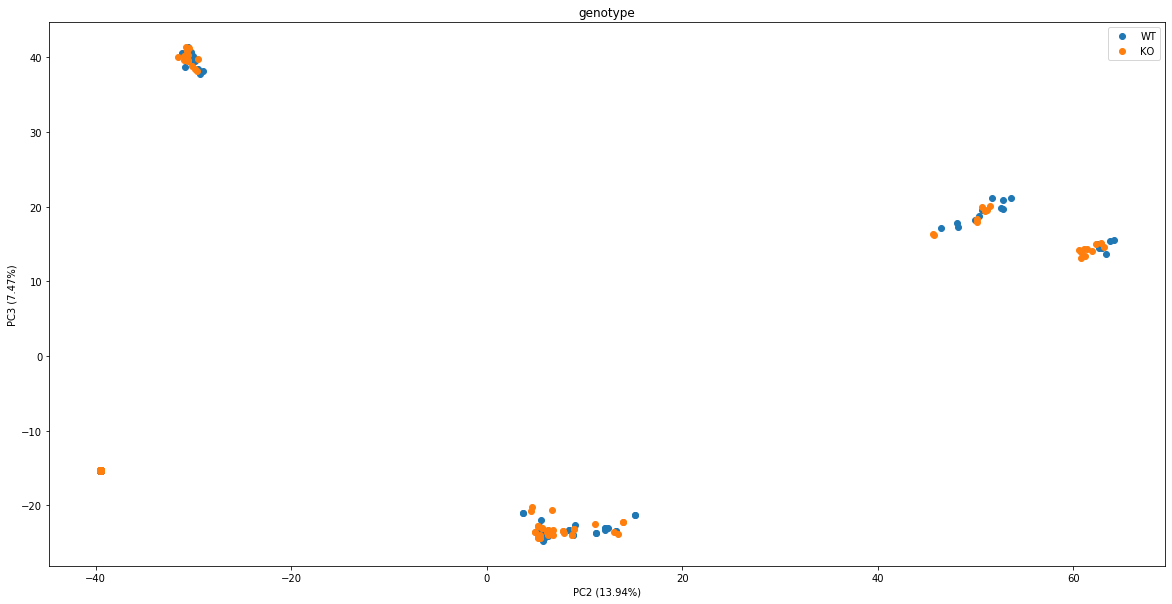

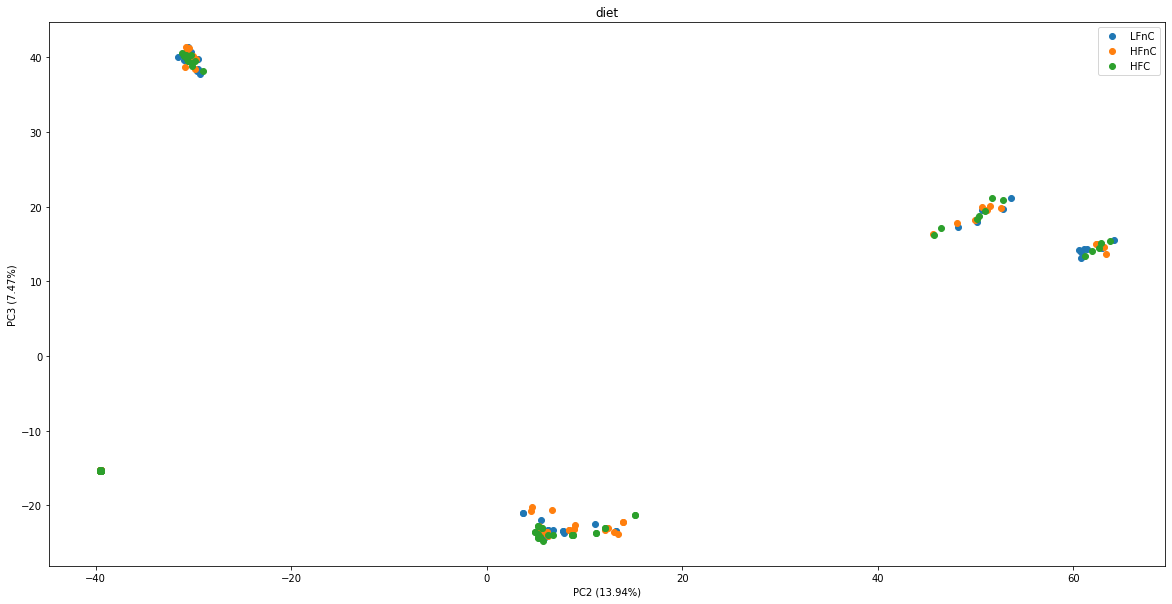

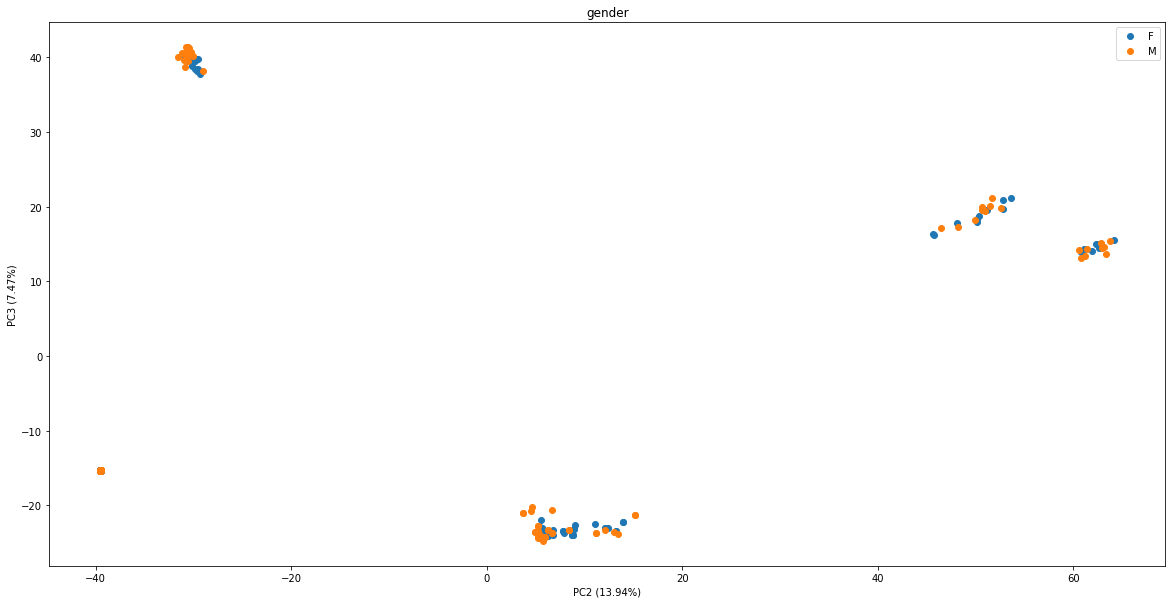

In [15]:
for c in combinations(range(3), 2):
    i1 = c[0]
    i2 = c[1]
    for group in groups:
        for subgroup, label in zip(groups[group], labels[group]):
            locs = np.isin(models, subgroup)
            plt.plot(comps[locs,i1], comps[locs,i2],"o", label=label)
            
        #for model, x, y in zip(models, comps[:,i1], comps[:,i2]):        
        #    plt.text(x+0.05,y+0.05,model)

        plt.title(group)
        plt.xlabel("PC"+str(i1+1) + " (" + str(round(100*pca_explained[i1],2))+"%)")
        plt.ylabel("PC"+str(i2+1) + " (" + str(round(100*pca_explained[i2],2))+"%)")
        plt.legend()
        plt.gcf().set_size_inches(20,10)
        plt.savefig("figures_PCA_extended\\"+"PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+group+".pdf", format="pdf", bbox_inches = 'tight')
        plt.savefig("figures_PCA_extended\\"+"PC"+str(i1+1)+'_'+"PC"+str(i2+1)+'_'+group+".png", format="png", bbox_inches = 'tight')
        plt.show()

In [16]:
subgroup[0].split("_")[1]

'Fastcore'

In [17]:
groups

{'MEM': [['GSM1405507_Fastcore',
   'GSM1405508_Fastcore',
   'GSM1405509_Fastcore',
   'GSM1405510_Fastcore',
   'GSM1405511_Fastcore',
   'GSM1405512_Fastcore',
   'GSM1405513_Fastcore',
   'GSM1405514_Fastcore',
   'GSM1405515_Fastcore',
   'GSM1405516_Fastcore',
   'GSM1405517_Fastcore',
   'GSM1405518_Fastcore',
   'GSM1405519_Fastcore',
   'GSM1405520_Fastcore',
   'HFC_Fastcore',
   'HFC_Fastcore',
   'HFC_Fastcore',
   'HFnC_Fastcore',
   'HFnC_Fastcore',
   'HFnC_Fastcore',
   'LFnC_Fastcore',
   'LFnC_Fastcore',
   'LFnC_Fastcore',
   'GSM1405485_Fastcore',
   'GSM1405486_Fastcore',
   'GSM1405487_Fastcore',
   'GSM1405488_Fastcore',
   'GSM1405489_Fastcore',
   'GSM1405490_Fastcore',
   'GSM1405491_Fastcore',
   'GSM1405492_Fastcore',
   'GSM1405493_Fastcore',
   'GSM1405494_Fastcore',
   'GSM1405495_Fastcore',
   'GSM1405496_Fastcore',
   'GSM1405497_Fastcore',
   'GSM1405498_Fastcore',
   'GSM1405499_Fastcore',
   'GSM1405500_Fastcore',
   'GSM1405501_Fastcore',
   'GSM140

# Sort and correlate (faster)

In [18]:
factors = list(groups.keys())
Rs = np.zeros((len(factors), 3))
rhos = np.zeros((len(factors), 3))


for ii, factor in enumerate(groups):
    scores1 = []
    scores2 = []
    scores3 = []
    for i in range(len(groups[factor])):
        idxs = np.array(np.where(np.isin(models, groups[factor][i])==True)).flatten()
        scores1.append(sorted(df.iloc[idxs, 0].values))
        scores2.append(sorted(df.iloc[idxs, 1].values))
        scores3.append(sorted(df.iloc[idxs, 2].values))
        
    for idx in permutations(range(len(scores1))):
        s1 = []
        s2 = []
        s3 = []        
        for i in idx:
            s1 += scores1[i]
            s2 += scores2[i]
            s3 += scores3[i]
            
        
        R_PC1 = pearsonr(np.arange(len(s1)), s1)[0]
        R_PC2 = pearsonr(np.arange(len(s2)), s2)[0]
        R_PC3 = pearsonr(np.arange(len(s3)), s3)[0]

        rho_PC1 = spearmanr(np.arange(len(s1)), s1)[0]
        rho_PC2 = spearmanr(np.arange(len(s2)), s2)[0]
        rho_PC3 = spearmanr(np.arange(len(s3)), s3)[0]

        Rs[ii, 0] = max(Rs[ii, 0], abs(R_PC1))
        Rs[ii, 1] = max(Rs[ii, 1], abs(R_PC2))
        Rs[ii, 2] = max(Rs[ii, 2], abs(R_PC3))

        rhos[ii, 0] = max(rhos[ii, 0], abs(rho_PC1))
        rhos[ii, 1] = max(rhos[ii, 1], abs(rho_PC2))
        rhos[ii, 2] = max(rhos[ii, 2], abs(rho_PC3))

        
        
    

## Postprocessing

### Pearson

In [19]:
Rs2 = Rs ** 2 # coefficient of determination
#Rs = Rs / np.sum(Rs, axis=0) # conversion to percentages
#Rs2 = Rs2 / np.sum(Rs2, axis=0) # conversion to percentages

In [20]:
#df_R = pd.DataFrame(data = Rs, columns = ['R(PC1)', 'R(PC2)', 'R(PC3)'])
#df_R['factor'] = groups.keys()

#df_R2 = pd.DataFrame(data = np.column_stack((Rs2,abs_Rs2)), columns = ['R2(PC1) [%]', 'R2(PC2) [%]', 'R2(PC3) [%]','R2(PC1)', 'R2(PC2)', 'R2(PC3)'])
df_R2 = pd.DataFrame(data = Rs2, columns = ['R2(PC1)', 'R2(PC2)', 'R2(PC3)'])
df_R2['factor'] = groups.keys()

#df_R = pd.merge(df_R, df_R2)
df_R2=df_R2.set_index('factor')



In [21]:
df_R2.to_csv("results_PCA_extended\\"+"pearson_variability_explained.csv")

### Spearman

In [22]:
rhos2 = rhos ** 2 # coefficient of determination
#rhos = rhos / np.sum(rhos, axis=0) # conversion to percentages
#rhos2 = rhos2 / np.sum(rhos2, axis=0) # conversion to percentages

In [23]:
#df_rho = pd.DataFrame(data = rhos, columns = ['Rho(PC1)', 'Rho(PC2)', 'Rho(PC3)'])
#df_rho['factor'] = groups.keys()

#df_rho2 = pd.DataFrame(data = np.column_stack((rhos2,abs_rhos2)), columns = ['Rho2(PC1) [%]', 'Rho2(PC2) [%]', 'Rho2(PC3) [%]','Rho2(PC1)', 'Rho2(PC2)', 'Rho2(PC3)'])
df_rho2 = pd.DataFrame(data = rhos2, columns = ['Rho2(PC1)', 'Rho2(PC2)', 'Rho2(PC3)'])
df_rho2['factor'] = groups.keys()

#df_rho = pd.merge(df_rho, df_rho2)
df_rho2=df_rho2.set_index('factor')

In [24]:
df_rho2

,Rho2(PC1),Rho2(PC2),Rho2(PC3)
factor,,,
MEM,0.955586,0.950847,0.956322
genotype,0.261684,0.263914,0.262668
diet,0.137295,0.116953,0.175601
gender,0.273436,0.292551,0.273666


In [25]:
df_rho2.to_csv("results_PCA_extended\\"+"spearman_variability_explained.csv")